# NER Tagging with CRF.  (60 Points out of 100)

In this part, you will use a CRF to implement a named entity recognition tagger.
We have implemented a CRF for you in crf.py along with some functions to build, and pad feature vectors. Your job is to add more features to learn a better tagger. Then you need to complete the traiing loop implementation.

Finally, you can checkout the code in `crf.py` -- reflect on CRFs and span tagging, and answer the discussion questions.


We will use the Hindi NER dataset at: https://github.com/cfiltnlp/HiNER

The first step would be to download the repo into your current folder of the Notebook

In [25]:
!git clone https://github.com/cfiltnlp/HiNER.git

fatal: destination path 'HiNER' already exists and is not an empty directory.


In [15]:
import torch

In [1]:
# This is so that you don't have to restart the kernel everytime you edit hmm.py

%load_ext autoreload
%autoreload 2

## First we load the data and labels. Feel free to explore them below.

Since we have provided a seperate train and dev split, there is not need to split the data yourself.

In [6]:
from crf import load_data, make_labels2i

train_filepath = "./HiNER/data/collapsed/train.conll"
dev_filepath = "./HiNER/data/collapsed/validation.conll"
labels_filepath = "./HiNER/data/collapsed/label_list"

train_sents, train_tag_sents = load_data(train_filepath)
dev_sents, dev_tag_sents = load_data(dev_filepath)
labels2i = make_labels2i(labels_filepath)

print("train sample", train_sents[2], train_tag_sents[2])
print()
print("labels2i", labels2i)

train sample ['रामनगर', 'इगलास', ',', 'अलीगढ़', ',', 'उत्तर', 'प्रदेश', 'स्थित', 'एक', 'गाँव', 'है।'] ['B-LOCATION', 'B-LOCATION', 'O', 'B-LOCATION', 'O', 'B-LOCATION', 'I-LOCATION', 'O', 'O', 'O', 'O']

labels2i {'<PAD>': 0, 'B-LOCATION': 1, 'B-ORGANIZATION': 2, 'B-PERSON': 3, 'I-LOCATION': 4, 'I-ORGANIZATION': 5, 'I-PERSON': 6, 'O': 7}


## Feature engineering. (Total 30 points)

Notice that we are **learning** features to some extent: we start with one unique feature for every possible word. You can refer to figure 8.15 in the textbook for some good baseline features to try.
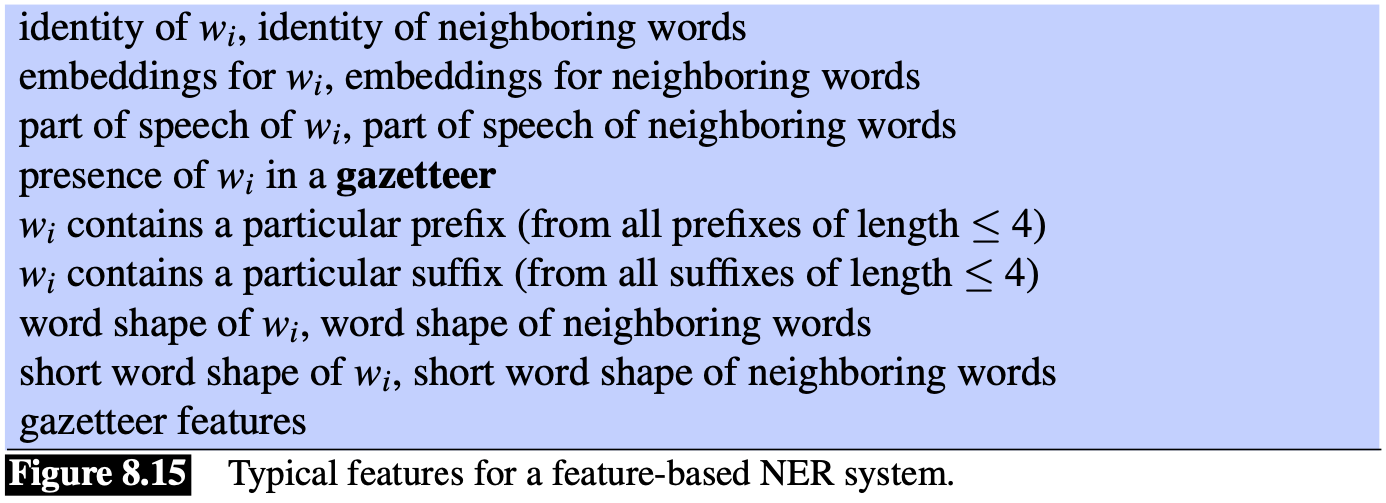

There is no need to worry about embeddings now.

### Hindi POS Tagger   (10 Points)

Although this step is not entirely necessary, if you want to use the HMM pos tagger to extract feature corresponding to the pos of the word in the sentence, we need to add this into the pipeline.

You get 10 points if you use your pos_tagger to featurize the sentences

In [22]:
from hmm import get_hindi_dataset
import pickle

words, tags, observation_dict, state_dict, all_observation_ids, all_state_ids = get_hindi_dataset()

# we need to add the id for unknown word (<unk>) in our observations vocab
UNK_TOKEN = '<unk>'

observation_dict[UNK_TOKEN] = len(observation_dict)
print("id of the <unk> token:", observation_dict[UNK_TOKEN])

## load the pos tagger 
# pos_tagger = pickle.load(open('hindi_pos_tagger.pkl', 'rb'))

def encode(sentences: List[List[str]]) -> List[List[int]]:
    """
    Using the observation_dict, convert the tokens to ids
    unknown words take the id for UNK_TOKEN
    """
    return [
        [observation_dict[t] if t in observation_dict else observation_dict[UNK_TOKEN]
            for t in sentence]
        for sentence in sentences]

def get_pos(pos_tagger, sentences) -> List[List[str]]:
    """
    The the pos tag for input sentences
    """
    sentence_ids = encode(sentences)
    decoded_pos_ids = pos_tagger.decode(sentence_ids)
    return [
        [tags[i] for i in d_ids]
        for d_ids in decoded_pos_ids
    ]

id of the <unk> token: 2186


### Feature Engineering Functions (20 Points)

In [8]:
from typing import List

# TODO: Update this function to add more features
#      You can check crf.py for how they are encoded, if interested.
def make_features(text: List[str]) -> List[List[int]]:
    """Turn a text into a feature vector.

    Args:
        text (List[str]): List of tokens.

    Returns:
        List[List[int]]: List of feature Lists.
    """
    feature_lists = []
    for i, token in enumerate(text):
        feats = []
        # We add a feature for each unigram.
        feats.append(f"word={token}")
        # TODO: Add more features here
        
        # We append each feature to a List for the token.
        feature_lists.append(feats)

    return feature_lists

In [23]:
def featurize(sents: List[List[str]]) -> List[List[List[str]]]:
    """Turn the sentences into feature Lists.
    
    Eg.: For an input of 1 sentence:
         [[['I','am','a','student','at','CU','Boulder']]]
        Return list of features for every token for every sentence like:
        [[
         ['word=I',  'prev_word=<S>','pos=PRON',...],
         ['word=an', 'prev_word=I'  , 'pos=VB' ,...],
         [...]
        ]]

    Args:
        sents (List[List[str]]): A List of sentences, which are Lists of tokens.

    Returns:
        List[List[List[str]]]: A List of sentences, which are Lists of feature Lists
    """
    feats = []
    for sent in sents:
        # Gets a List of Lists of feature strings
        feats.append(make_features(sent))
        
        # TO DO: Get pos tags
        # sent_tags = get_pos(pos_tagger, [sent])[0]

    return feats

## Finish the training loop.   (10 Points)

See the previous homework, and fill in the missing parts of the training loop.

In [19]:
from crf import f1_score, predict, PAD_SYMBOL

# TODO: Implement the training loop
# HINT: Build upon what we gave you for HW2.
# See cell below for how we call this training loop.

def training_loop(
    num_epochs,
    batch_size,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model,
    labels2i,
    pad_feature_idx
):
    raise NotImplementedError
    # TODO: Zip the train features and labels
    
    # TODO: Randomize them, while keeping them paired.
    
    # TODO: Build batches
    print("Training...")
    for i in range(num_epochs):
        losses = []
        for batch in tqdm(batches):
            # Here we get the features and labels, pad them,
            # and build a mask so that our model ignores PADs
            # We have abstracted the padding from you for simplicity, 
            # but please reach out if you'd like learn more.
            features, labels = zip(*batch)
            features = pad_features(features, pad_feature_idx)
            features = torch.stack(features)
            # Pad the label sequences to all be the same size, so we
            # can form a proper matrix.
            labels = pad_labels(labels, labels2i[PAD_SYMBOL])
            labels = torch.stack(labels)
            mask = (labels != labels2i[PAD_SYMBOL])
            # TODO: Empty the dynamic computation graph

            # TODO: Run the model. Since we use the pytorch-crf model,
            # our forward function returns the positive log-likelihood already.
            # We want the negative log-likelihood. See crf.py forward method in NERTagger
            
            # TODO: Backpropogate the loss through our model

            # TODO: Update our coefficients in the direction of the gradient.

            # TODO: Store the losses for logging
        
        # TODO: Log the average Loss for the epoch
        
        # TODO: make dev predictions with the `predict()` function
        
        # TODO: Compute F1 score on the dev set and log it.
        
        
    # Return the trained model
    return model

## Run the training loop   (10 Points)

We have provided the code here, but you can try different hyperparameters and test multiple runs.

In [ ]:
from crf import build_features_set
from crf import make_features_dict
from crf import encode_features, encode_labels
from crf import NERTagger

# Build the model and featurized data
train_features = featurize(train_sents)
dev_features = featurize(dev_sents)

# Get the full inventory of possible features
all_features = build_features_set(train_features)
# Hash all features to a unique int.
features_dict = make_features_dict(all_features)
# Initialize the model.
model = NERTagger(len(features_dict), len(labels2i))

encoded_train_features = encode_features(train_features, features_dict)
encoded_dev_features = encode_features(dev_features, features_dict)
encoded_train_labels = encode_labels(train_tag_sents, labels2i)
encoded_dev_labels = encode_labels(dev_tag_sents, labels2i)

# TODO: Play with hyperparameters here.
num_epochs = 30
batch_size = 16
LR=0.05
optimizer = torch.optim.SGD(model.parameters(), LR)

model = training_loop(
    num_epochs,
    batch_size,
    encoded_train_features,
    encoded_train_labels,
    encoded_dev_features,
    encoded_dev_labels,
    optimizer,
    model,
    labels2i,
    features_dict[PAD_SYMBOL]
)

## Quiz (10 Points)

### 1. Look at the `NERTagger` class in crf.py

    a) What does the CRF add to our model that makes it different from the sentiment classifier?

    b) Why is this helpful for NER?

### 2. Why computing F1 here is not straightforward?

Hint: Refer to the class in which Jim went over the evaluation metrics for NER 